In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
train_data = pd.read_csv(train.csv')
test_data = pd.read_csv(test.csv')

In [28]:
columns_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
train_data_cleaned = train_data.drop(columns=columns_to_drop)
test_data_cleaned = test_data.drop(columns=columns_to_drop)

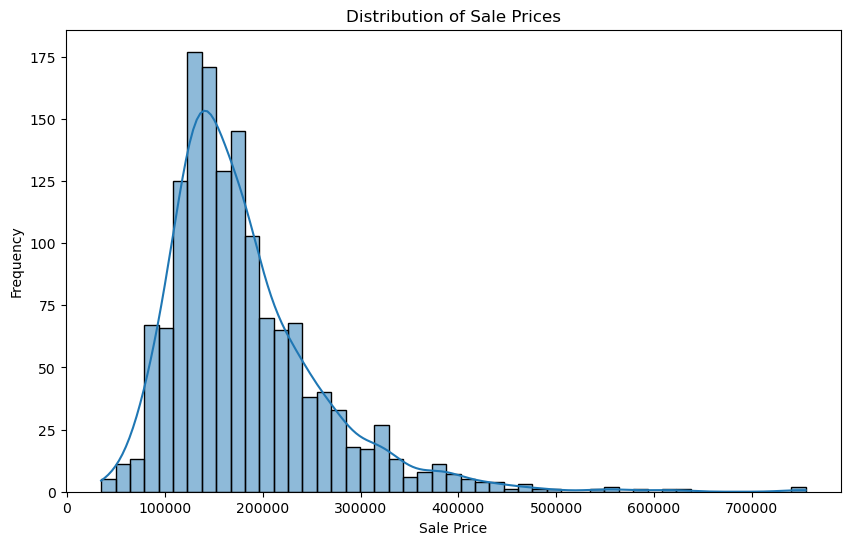

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data_cleaned['SalePrice'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

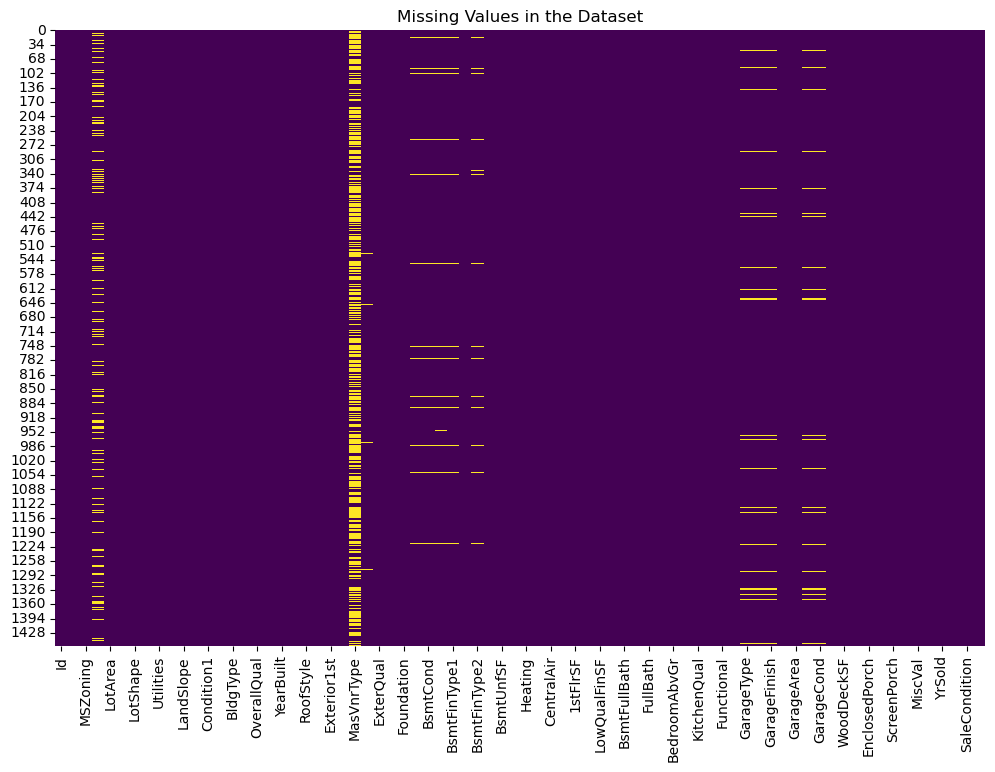

In [30]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_data_cleaned.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in the Dataset')
plt.show()

In [31]:
numerical_cols = train_data_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train_data_cleaned.select_dtypes(include=['object']).columns

In [32]:
for col in numerical_cols:
    train_data_cleaned[col].fillna(train_data_cleaned[col].median(), inplace=True)

for col in categorical_cols:
    train_data_cleaned[col].fillna(train_data_cleaned[col].mode()[0], inplace=True)

for col in numerical_cols:
    if col in test_data_cleaned.columns:
        test_data_cleaned[col].fillna(train_data_cleaned[col].median(), inplace=True)

for col in categorical_cols:
    if col in test_data_cleaned.columns:
        test_data_cleaned[col].fillna(train_data_cleaned[col].mode()[0], inplace=True)

In [33]:
train_data_cleaned['TotalSF'] = train_data_cleaned['TotalBsmtSF'] + train_data_cleaned['1stFlrSF'] + train_data_cleaned['2ndFlrSF']
test_data_cleaned['TotalSF'] = test_data_cleaned['TotalBsmtSF'] + test_data_cleaned['1stFlrSF'] + test_data_cleaned['2ndFlrSF']

In [34]:
train_data_cleaned = pd.get_dummies(train_data_cleaned)
test_data_cleaned = pd.get_dummies(test_data_cleaned)

In [35]:
train_data_cleaned, test_data_cleaned = train_data_cleaned.align(test_data_cleaned, join='left', axis=1)

In [36]:
test_data_cleaned = test_data_cleaned.fillna(0)

In [37]:
X = train_data_cleaned.drop(['Id', 'SalePrice'], axis=1)
y = train_data_cleaned['SalePrice']

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=3)

In [39]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(test_data_cleaned.drop(['Id', 'SalePrice'], axis=1))

In [13]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [14]:
xgb_model = XGBRegressor(random_state=42)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', StandardScaler()),
    ('regressor', xgb_model)
])


In [15]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

param_grid_xgb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 5]
}

In [16]:
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor', StandardScaler()),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importa...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'regressor__learning_rate': [0.01, 0.1],
                         'regressor__max_depth': [3, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

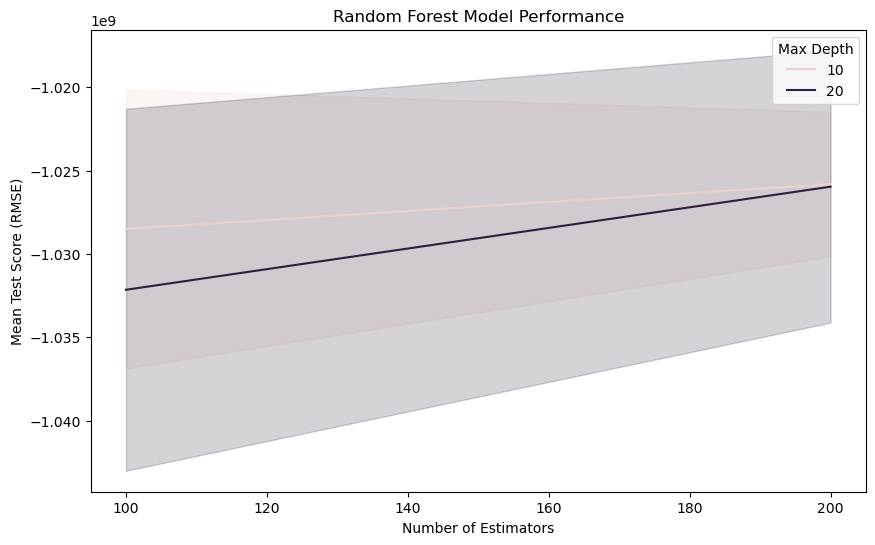

In [40]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='param_n_estimators', y='mean_test_score', hue='param_max_depth', data=grid_search_rf.cv_results_)
plt.title('Random Forest Model Performance')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score (RMSE)')
plt.legend(title='Max Depth')
plt.show()

In [17]:
best_rf = grid_search_rf.best_estimator_
rf_rmse = np.sqrt(-grid_search_rf.best_score_)
print(f"Best Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Random Forest RMSE: {rf_rmse}")

Best Random Forest parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest RMSE: 31903.185554752465


In [18]:
best_xgb = grid_search_xgb.best_estimator_
xgb_rmse = np.sqrt(-grid_search_xgb.best_score_)
print(f"Best XGBoost parameters: {grid_search_xgb.best_params_}")
print(f"XGBoost RMSE: {xgb_rmse}")

Best XGBoost parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
XGBoost RMSE: 31272.342380376223


In [19]:
y_pred = best_xgb.predict(X_valid)
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Validation RMSE: {rmse_valid}")

Validation RMSE: 25418.694781519105


In [20]:
test_predictions = best_xgb.predict(X_test)

In [21]:
submission = pd.DataFrame({'Id': test_data_cleaned['Id'], 'SalePrice': test_predictions})
submission.to_csv('submission.csv', index=False)

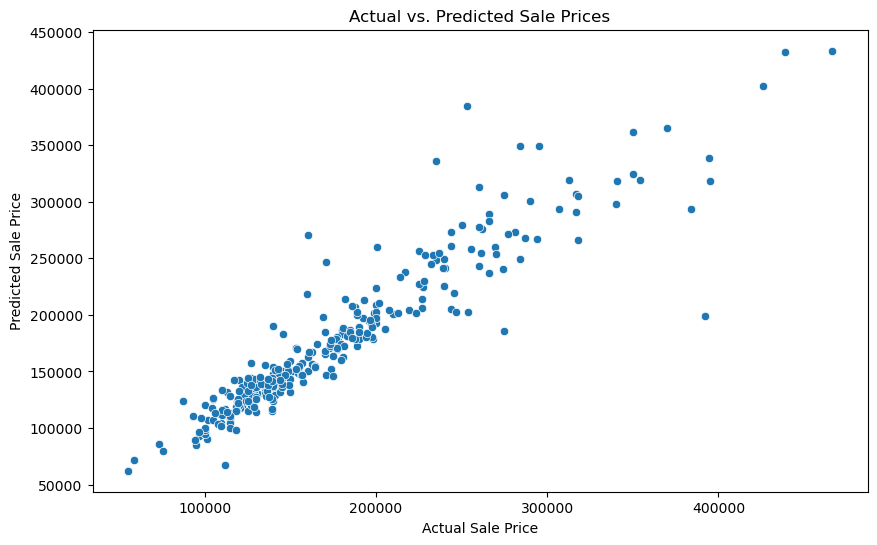

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid, y=y_pred)
plt.title('Actual vs. Predicted Sale Prices')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()